# Network analysis of CRISPR essential genes in pancreatic cancer

------------

Author: Brin Rosenthal (sbrosenthal@ucsd.edu)

-----------

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns

import community
import matplotlib_venn

import mygene
mg = mygene.MyGeneInfo()

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

% matplotlib inline

import visJS2jupyter.visJS_module
import visJS2jupyter.visualizations

import sys
# FIX THIS PATH LATER
sys.path.append('/Users/brin/Google_Drive/UCSD/cluster_code/')

# Load plotting results for localization 
# FIX THIS PATH
sys.path.append('/Users/brin/Google_Drive/UCSD/cluster_code/network_propagation/')
import plotting_results

import load_interactomes

GenRev not found, steiner wont work


# Load the CRISPR data and RNAseq data (now in same file)

Update 12/07/17: Use union of RNAseq fdr significant genes and CRISPR significant genes as seeds

3DGvs3DV --> selects genes sensitive to drug   
3DVvsT21 --> selects genes essential for 'stemness'

In [2]:
# ---- Now updated file from Nikki ------
# ---- Create seed sets

rna_df = pd.read_excel('../data/rnaseq_crispr_171207.xlsx',sheetname='RNA-seq',index_col='symbol')
rna_df.head()
# crispr_T21_df = pd.read_csv('../data/RS_MAGeCK_comparison/RS_T0_T21.gene_summary.txt',sep='\t',index_col='Unnamed: 0')
# crispr_T21_df.head()

# crispr_3DV_df = pd.read_csv('../data/RS_MAGeCK_comparison/RS_3DV.gene_summary.txt',sep='\t',index_col='Unnamed: 0')
# crispr_3DV_df.head(10)

,gene,description,NEG1,NEG2,NEG3,GFP1,GFP2,GFP3,NEG,GFP,log2 GFP/NEG,fc GFP/NEG,lfdr GFP-NEG,fdr GFP-NEG
symbol,,,,,,,,,,,,,,
Slc10a2,20494,"solute carrier family 10, member 2",3,4,5,198,202,218,4,206,5.436202,43.297196,0.000387,0.000387
G0s2,14373,G0/G1 switch gene 2,2933,2180,3846,23,27,31,2986,27,-6.731514,-106.264347,0.000621,0.000504
Cd177,68891,CD177 antigen,3455,3029,3022,52,79,79,3169,70,-5.513000,-45.664450,0.000688,0.000565
Il1r2,16178,"interleukin 1 receptor, type II",5689,7159,7494,125,130,77,6781,111,-5.959055,-62.209147,0.001087,0.000696
Gpr84,80910,G protein-coupled receptor 84,203,190,213,6,6,9,202,7,-4.795802,-27.776680,0.001274,0.000812


In [3]:
rna_df.loc['Mmp8']

gene                                17394
description     matrix metallopeptidase 8
NEG1                                 3321
NEG2                                 2823
NEG3                                  934
GFP1                                   26
GFP2                                  203
GFP3                                   32
NEG                                  2359
GFP                                    87
log2 GFP/NEG                     -5.21156
fc GFP/NEG                       -37.0541
lfdr GFP-NEG                      0.72239
fdr GFP-NEG                      0.336135
Name: Mmp8, dtype: object

In [4]:
#crispr_3DV_df = pd.read_excel('../data/rnaseq_crispr_171207.xlsx',sheetname='Crispr 3DV',skiprows=1,
#                             index_col='Unnamed: 0')

# load new crispr data
crispr_3DV_df = pd.read_csv('../data/3DV_enhancers_p_fdr_180119.txt',sep='\t',index_col='Unnamed: 0')

crispr_3DV_df.head()

,alphaT_1,alphaT_2,alphaT_3,mean alphaT,permutation p,permutation FDR
mmu-mir-6979,-1.895770,-3.212108,-2.038180,-2.382019,4.718317e-08,0.0010
mmu-mir-669a-2,-2.579136,-2.589178,-0.826302,-1.998205,7.077475e-07,0.0075
Ssxb5,-2.012572,-1.778212,-1.890120,-1.893635,7.077475e-07,0.0050
mmu-mir-1249,-0.559810,-1.883050,-3.241975,-1.894945,2.076059e-06,0.0110
Defa26,-0.556956,-1.673242,-3.428127,-1.886108,2.406341e-06,0.0102


In [5]:
crispr_3DV_df.loc['Rorc']

alphaT_1          -0.888965
alphaT_2          -0.466446
alphaT_3          -1.190371
mean alphaT       -0.848594
permutation p      0.001485
permutation FDR    0.425392
Name: Rorc, dtype: float64

In [6]:
len(rna_df)

13787

In [7]:
print(len(crispr_3DV_df[crispr_3DV_df['permutation FDR']<0.5]))

94


In [8]:
# load the intersection dataset
#crispr_rna_expressed = pd.read_excel('../data/rnaseq_crispr_171207.xlsx',sheetname='Overlap; expressed by RNA',
#                                    skiprows=1)
#crispr_rna_expressed = crispr_rna_expressed['symbol'].tolist()

rna_expressed = rna_df.index.tolist()

crispr_rna_expressed = crispr_3DV_df[crispr_3DV_df['permutation FDR']<0.5]
crispr_rna_expressed = crispr_rna_expressed.loc[rna_expressed].dropna()
crispr_rna_expressed = crispr_rna_expressed.sort_values('permutation FDR',ascending=True)

print(len(crispr_rna_expressed))
crispr_rna_expressed.head()
crispr_rna_expressed = crispr_rna_expressed.index.tolist() # cast to gene names

57


In [9]:
# load intersection dataset filtered by FC
#crispr_rna_fc = pd.read_excel('../data/rnaseq_crispr_171207.xlsx',sheetname='Overlap; RNA FC',skiprows=1)
#crispr_rna_fc = crispr_rna_fc['symbol'].tolist()

rna_FC2 = rna_df[rna_df['log2 GFP/NEG'].abs()>2]
crispr_rna_fc =  crispr_3DV_df[crispr_3DV_df['permutation FDR']<0.5] # filter by FDR
crispr_rna_fc = crispr_rna_fc.loc[rna_FC2.index.tolist()].dropna() # filter by rna FC
crispr_rna_fc = crispr_rna_fc.sort_values('permutation FDR',ascending=True)

print(len(crispr_rna_fc))
crispr_rna_fc
crispr_rna_fc = crispr_rna_fc.index.tolist() # cast to gene names

10


In [10]:
crispr_rna_fc

[u'Gm3776',
 u'BC100530',
 u'Cd300lh',
 u'Gm10334',
 u'Sox4',
 u'Klra18',
 u'Pard6b',
 u'Smo',
 u'Rorc',
 u'Ccdc120']

# Load the super-enhancer list

In [11]:
SE_df = pd.read_excel('../data/Allds_superhistone_z.xlsx')
SE_df.head()

,PeakID..cmd.annotatePeaks.pl.Allds_superhistone.txt.mm10..raw..d.GFP.ds..GFP...,Chr,Start,End,Strand,Peak.Score,Focus.Ratio.Region.Size,Annotation,Detailed.Annotation,Distance.to.TSS,...,Nearest.Unigene,Nearest.Refseq,Nearest.Ensembl,Gene.Name,Gene.Alias,Gene.Description,Gene.Type,GFP.ds..Tag.Count.in.given.bp..16140595.0.Total..normalization.factor...1..effective.total...10000000.,GFP...Tag.Count.in.given.bp..15257948.0.Total..normalization.factor...1..effective.total...10000000.,z
0,chr9-622,chr9,123923162,124150224,+,3202.4,1.787,Intergenic,C-rich|Low_complexity|Low_complexity,14722,...,Mm.57050,NM_009914,ENSMUSG00000035448,Ccr3,CC-CKR3|CKR3|Cmkbr1l2|Cmkbr3,chemokine (C-C motif) receptor 3,protein-coding,7238,2815,-4.388891
1,chr19-21104,chr19,29355074,29529386,+,2993.8,1.380,"intron (NM_021396, intron 3 of 5)",L1_Mur1|LINE|L1,31311,...,Mm.116737,NM_021396,NaN,Pdcd1lg2,B7-DC|Btdc|F730015O22Rik|PD-L2,programmed cell death 1 ligand 2,protein-coding,6486,2914,-3.718446
2,chr5-45710,chr5,92666574,93052183,+,3645.1,2.759,"intron (NM_001077595, intron 1 of 9)","intron (NM_001077595, intron 1 of 9)",-38615,...,Mm.46014,NM_015756,ENSMUSG00000029381,Shroom3,AL022960|D5Ertd287e|Shrm|Shrm3,shroom family member 3,protein-coding,3858,7587,3.142954
3,chr11-53492,chr11,115808452,115977121,+,2703.6,2.158,"3 UTR (NM_130454, exon 19 of 19)","3 UTR (NM_130454, exon 19 of 19)",-7353,...,Mm.275740,NM_183259,ENSMUSG00000048442,Smim5,2210020M01Rik,small integral membrane protein 5,protein-coding,2917,5572,3.007767
4,chr5-44879,chr5,53336288,53665432,+,3673.7,3.078,Intergenic,Intergenic,-54919,...,Mm.209292,NM_009035,ENSMUSG00000039191,Rbpj,AI843960|CBF1|Igkjrb|Igkrsbp|RBP-J|RBP-J kappa...,recombination signal binding protein for immun...,protein-coding,7569,3966,-3.003606


In [12]:
SE_sig = SE_df[SE_df['z'].abs()>1.5]
SE_sig = SE_sig[['Gene.Name','z']]
SE_sig.index=SE_sig['Gene.Name']
SE_sig

,Gene.Name,z
Gene.Name,,
Ccr3,Ccr3,-4.388891
Pdcd1lg2,Pdcd1lg2,-3.718446
Shroom3,Shroom3,3.142954
Smim5,Smim5,3.007767
Rbpj,Rbpj,-3.003606
4930459C07Rik,4930459C07Rik,-2.988616
2610035D17Rik,2610035D17Rik,2.972612
Wnt7b,Wnt7b,2.859573
Rin3,Rin3,-2.840593


# Load Interactome (for now- mouse STRING)

In [13]:
# HIGH CONFIDENCE STRING
G_str = load_interactomes.load_STRING(datafile='/Users/brin/Documents/CCBB_tickets_data/STRING/mouse/10090.protein.links.v10.5.txt',
                                     conf_thresh=700,species='mouse',cap_choice='lower')

# MEDIUM CONFIDENCE STRING
# G_str = load_interactomes.load_STRING(datafile='/Users/brin/Documents/CCBB_tickets_data/STRING/mouse/10090.protein.links.v10.5.txt',
#                                      conf_thresh=400,species='mouse',cap_choice='lower')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-19698...done.
Finished.
179 input query terms found dup hits:
	[(u'ENSMUSP00000024026', 3), (u'ENSMUSP00000094676', 2), (u'ENSMUSP00000067008', 2), (u'ENSMUSP00000
581 input query terms found no hit:
	[u'ENSMUSP00000137120', u'ENSMUSP00000128098', u'ENSMUSP00000136100', u'ENSMUSP00000045240', u'ENSMU
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
ENSMUSP00000000001    Gnai3
ENSMUSP00000000003     Pbsn
ENSMUSP0000000

In [14]:
# remove UBC
if 'Ubc' in G_str.nodes():
    G_str.remove_node('Ubc')



In [15]:
'Lipt2' in G_str.nodes()

True

In [16]:
np.intersect1d(crispr_rna_fc,G_str.nodes())

array([u'BC100530', u'Ccdc120', u'Gm10334', u'Klra18', u'Pard6b', u'Rorc',
       u'Smo', u'Sox4'], dtype='<U18')

In [17]:
len(G_str.edges())

910012

In [18]:
def load_GIANT(data_path,conf_thresh = 0,num_edges=500000,cap_choice='upper'):
    '''
    Function to load GIANT data into a networkx network.  
    
    Keep the top num_edges edges (entire graph is too unwieldy), if conf_thresh is not set,
    or keep all edges > conf_thresh, if conf_thresh is > 0
    '''
    
    # ----------------------------------------------------------------------------
    # --------------- read line-by-line -- more memory efficient -----------------
    edge_list=[]
    counter=-1
    with open(data_path,"r") as Gtemp:
        for line in Gtemp:
            counter+=1
            if (counter % 2000000)==0:
                print(counter)
                print(len(edge_list))
            split_line = line.strip('\n').split('\t')
            int_line = (int(split_line[0]),int(split_line[1]),np.float(split_line[2]))
            if int_line[2]>conf_thresh: # if confidence > conf_thresh, add it to the edge_list
                edge_list.append(int_line)

    Gtemp.close()  
    
    G_giant = nx.Graph()
    G_giant.add_weighted_edges_from(edge_list)
    
    # ----------------------------------------------------------------------------
    # ------------ read in with pandas- less efficient but possibly faster? ------
    
#     GIANT_temp = pd.read_csv(data_path,sep='\t',names=['gene1','gene2','post_prob'])
#     # sort it
#     GIANT_temp = GIANT_temp.sort_values('post_prob',ascending=False)
    
    
#     # only take the top 500k edges if conf_thresh==0
#     if conf_thresh==0:
#         GIANT_temp = GIANT_temp.head(num_edges)
#     else:
#         GIANT_temp = GIANT_temp[GIANT_temp['post_prob']>conf_thresh]
    
#     # make the network (converting to gene symbol)
#     G_giant = nx.Graph()
#     G_giant.add_weighted_edges_from(zip(GIANT_temp['gene1'],GIANT_temp['gene2'],GIANT_temp['post_prob']))
    # ----------------------------------------------------------------------------

    # convert from ensembleID to gene symbol
    genes_temp = G_giant.nodes()

    mg_temp = mg.querymany(genes_temp,fields='symbol')
    entrez_list = [x['query'] for x in mg_temp]
    symbol_list = [x['symbol'] if 'symbol' in x.keys() else 'None' for x in mg_temp]
    entrez_to_symbol = dict(zip(entrez_list,symbol_list))
    entrez_to_symbol = pd.Series(entrez_to_symbol)

    # relabel nodes with symbols
    G_giant = nx.relabel_nodes(G_giant,dict(zip(G_giant.nodes(),[str(g) for g in genes_temp]))) # make them strings first
    G_giant = nx.relabel_nodes(G_giant,dict(entrez_to_symbol[entrez_to_symbol!='None']))  # only keep the proteins that have associated genes
    
    # check which cap_choice- if lower, change node names.  If upper, do nothing
    if cap_choice=='lower':
        nodes_lower = [n[0].upper()+n[1:].lower() for n in G_giant]
        
        G_giant = nx.relabel_nodes(G_giant,dict(zip(G_giant.nodes(),nodes_lower)))
    
    return G_giant

In [26]:
G_giant = load_GIANT('/Users/brin/Documents/CCBB_tickets_data/GIANT/pancreas_top',conf_thresh=0.2,cap_choice='lower')

0
0
2000000
2486
4000000
2495
6000000
2517
8000000
2529
10000000
2674
12000000
3432
14000000
4004
16000000
4006
18000000
4306
20000000
4333
22000000
9487
24000000
116445
26000000
198963
28000000
213952
30000000
235190
32000000
250963
34000000
295303
36000000
357208
38000000
395447
40000000
431375
42000000
446883
44000000
472916
46000000
511728
48000000
532640
50000000
534578
52000000
542367
54000000
561537
56000000
637325
58000000
699148
60000000
751872
62000000
760186
64000000
802766
querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-10663...done.
Finished.
15 input query terms found no hit:
	[u'644504', u'1313', u'333931', u'8475', u'440264', u'170549', u'84786', u'414327', u'100131599', u'
Pass "returnall=True" to return complete lists of duplicate or mis

In [27]:
# save the processed graph
#nx.write_gpickle(G_giant,'/Users/brin/Documents/CCBB_tickets_data/GIANT/G_pancreas_top.2.gpickle')

In [63]:
# load the processed graph
G_giant = nx.read_gpickle('/Users/brin/Documents/CCBB_tickets_data/GIANT/G_pancreas_top.2.gpickle')

# Select which interactome to use

In [19]:
Gint = G_str #G_str

if 'None' in Gint.nodes():
    Gint.remove_node('None')


In [20]:
# seeds_crispr = crispr_3DV_df[crispr_3DV_df['eBayes lfdr']<0.2].index.tolist()
# print(len(seeds_crispr))

# seeds_rna = rna_df[rna_df['lfdr GFP-NEG']<0.01].index.tolist()
# print(len(seeds_rna))

# seeds_both = list(np.unique(seeds_crispr+seeds_rna))
# len(seeds_both)

In [21]:
# print(len(np.intersect1d(seeds_crispr,Gint.nodes())))
# print(len(np.intersect1d(seeds_rna,Gint.nodes())))

In [22]:
print(len(np.intersect1d(crispr_rna_expressed,Gint.nodes())))

49


In [23]:
print((np.intersect1d(crispr_rna_fc,Gint.nodes())))

[u'BC100530' u'Ccdc120' u'Gm10334' u'Klra18' u'Pard6b' u'Rorc' u'Smo'
 u'Sox4']


In [24]:
'Wnt7a' in Gint.nodes()

True

# How localized are focal gene set on interactome?

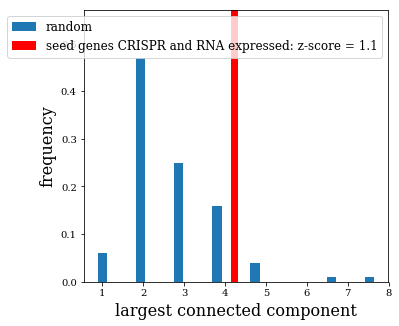

In [24]:
# localization of DNV sets
genes_best_in_graph = np.intersect1d(Gint.nodes(),crispr_rna_expressed)


# plot the largest connected component of genes in disorder 1
num_reps=100
LCC_size_disease, LCC_size_rand = plotting_results.compare_LCC(set(genes_best_in_graph),Gint,num_reps=num_reps,
                                                               shuffle_edges=False,print_flag=False)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plotting_results.plot_disease_LCC(LCC_size_disease, LCC_size_rand,disease_name='seed genes CRISPR and RNA expressed')
#plt.title(int_name,fontsize=14)





In [25]:
for g in genes_best_in_graph:
    print(g)

Aaas
Cars2
Chek1
Dmap1
Dolk
Exoc3
Foxo1
Gm10334
Hnrnpk
Idi1
Lipt2
Lss
Mau2
Mrps15
Mrps24
N6amt1
Osgep
Pard6b
Polg
Prpf8
Psmb6
Ptprm
Rorc
Rpia
Rpl3
Rps16
Sars2
Scin
Senp6
Sf1
Smo
Sox4
Spry1
Srm
Thoc2
Ucp2
Wdr1
Wdr25
Zfp523


# Make a network out of these significant genes, draw it

In [25]:
# development versions of return_node_to_color and return_edge_to_color

def return_node_to_color(G,field_to_map='degree',cmap=mpl.cm.jet,alpha = 1.0, color_vals_transform = None,ceil_val=10,
                        color_max_frac = 1.0,color_min_frac = 0.0,vmin=None,vmax=None):
    

    '''
    Function to return a dictionary mapping nodes (keys) to colors (values), based on the selected field_to_map.
        - field_to_map must be a node attribute
        - cmap must be a valid matplotlib colormap
        - color_max_frac and color_min_frac allow user to set lower and upper ranges for colormap
    
    '''
    
    
    
    nodes_with_data = [(n[0],n[1][field_to_map]) for n in G.nodes(data=True)]
    
    
    if color_vals_transform == 'log':
        nodes,data = zip(*nodes_with_data)
        min_dn0 = np.nanmin([d for d in data if d>0])
        data = [np.log(np.max([d,min_dn0])) for d in data]  # set the zero d values to minimum non0 value
        data = [(d-np.nanmin(data)) for d in data] # shift so we don't have any negative values
        nodes_with_data = zip(nodes,data)
        
    elif color_vals_transform == 'sqrt':
        nodes,data = zip(*nodes_with_data)
        data = [np.sqrt(d) for d in data]
        nodes_with_data = zip(nodes,data)
        
    elif color_vals_transform == 'ceil':
        nodes,data = zip(*nodes_with_data)
        data = [min(d,ceil_val) for d in data]
        nodes_with_data = zip(nodes,data)
    else:
        nodes,data = zip(*nodes_with_data)
        
    # if vmin and vmax aren't set, set them to min and max of the data
    if vmin == None:
        vmin = np.nanmin(data)
    if vmax == None:
        vmax = np.nanmax(data)
        
    node_to_mapField = dict(nodes_with_data)
    
    color_to_mult = 256*(color_max_frac-color_min_frac)
    color_to_add = 256*color_min_frac
    print(color_to_mult)
    print(color_to_add)
    print(np.nanmax(list(node_to_mapField.values())))
    
    color_list = [np.multiply(cmap(int(float(node_to_mapField[d]-vmin)/(vmax-vmin)*color_to_mult+color_to_add)),256) 
                  if ~np.isnan(node_to_mapField[d])
                  else [np.nan]
                  for d in G.nodes()]
    
    color_list = [(int(c[0]),int(c[1]),int(c[2]),alpha) 
                  if ~np.isnan(c[0])
                  else (200,200,200,alpha)
                  for c in color_list]

    node_to_color = dict(zip(G.nodes(),['rgba'+str(c) for c in color_list]))
    
    return node_to_color

def return_edge_to_color(G,field_to_map='degree',cmap=mpl.cm.jet,alpha = 1.0, color_vals_transform = None,ceil_val=10,
                        vmin=None,vmax=None):
    
    
    '''
    Function to return a dictionary mapping edges (keys) to colors (values), based on the selected field_to_map.
        - field_to_map must be an edge attribute
        - cmap must be a valid matplotlib colormap
    
    '''
    
    edges_with_data = [(e[0],e[1],e[2][field_to_map]) for e in G.edges(data=True)]
    
    edges1,edges2,data = zip(*edges_with_data)
    
    
    
    
    if color_vals_transform == 'log':
        data = [np.log(d) for d in data]
        data = [(d-np.min(data)) for d in data] # shift so we don't have any negative values
        edges_with_data = zip(zip(edges1,edges2),data)
        
    elif color_vals_transform == 'sqrt':
        data = [np.sqrt(d) for d in data]
        edges_with_data = zip(zip(edges1,edges2),data)
        
    elif color_vals_transform == 'ceil':
        data = [max(d,ceil_val) for d in data]
        edges_with_data = zip(zip(edges1,edges2),data)
    else:
        
        edges_with_data = zip(zip(edges1,edges2),data)
        
    # if vmin and vmax aren't set, set them to min and max of the data
    if vmin == None:
        vmin = np.nanmin(data)
    if vmax == None:
        vmax = np.nanmax(data)
        
    edge_to_mapField = dict(edges_with_data)
    
    color_list = [np.multiply(cmap(int(float(edge_to_mapField[d]-vmin)/(vmax-vmin)*256)),256) for d in G.edges()]
    
    color_list = [(int(c[0]),int(c[1]),int(c[2]),alpha) for c in color_list]
    
    edge_to_color = dict(zip(G.edges(),['rgba'+str(c) for c in color_list]))
    
    return edge_to_color

def bias_position_by_partition(pos,partition,r=1.0,focal_partitions=None,scale_by_groupsize=False,
                              use_orig_angle=False):
    '''
    Bias the positions by partition membership, to group them together
    
    '''
    
    partition = pd.Series(partition)
    
    
    
    # if focal_partitions haven't been defined, use all of them
    if focal_partitions==None:
        focal_partitions = list(np.unique(partition))
    
    
    counter=-1
    for p in focal_partitions:
        counter+=1

        focal_nodes = partition[partition==p].index.tolist()
        
        # if use_orig_angle==True, move groups apart by their original angle
        if use_orig_angle:
            xlist = [pos[n][0] for n in focal_nodes]
            ylist = [pos[n][1] for n in focal_nodes]
            xmean = np.mean(xlist)
            ymean = np.mean(ylist)
            
            rho,phi = cart2pol(xmean,ymean)
        else:
            phi = float(counter)/(len(focal_partitions))*2*np.pi
        
        # if scale_by_groupsize==True, move smaller groups further towards periphery
        if scale_by_groupsize:
            rtemp=r*1.0/np.sqrt(len(focal_nodes))
        else:
            rtemp=r
        
        for n in focal_nodes:
            pos[n][0]+=pol2cart(rtemp,phi)[0]
            pos[n][1]+=pol2cart(rtemp,phi)[1]
            
    return pos

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

# Bottom-up approach: Just the CRISPR genes network is very sparse- use network propagation to connect subsets of genes

- Start propagation from Roman's essential genes


In [26]:
# make a table of filtering steps, for MS
crispr_sig = crispr_3DV_df[crispr_3DV_df['permutation FDR']<0.5].index.tolist()
seed_filters_df = pd.DataFrame(np.zeros((len(crispr_sig),6)),index=crispr_sig)
seed_filters_df.columns=['CRISPR fdr','RNAseq logFC', 'CRISPR-essential','RNA-expressed','RNA-DE','in_STRING']
seed_filters_df['CRISPR fdr'].loc[crispr_sig]=crispr_3DV_df.loc[crispr_sig]['permutation FDR']
seed_filters_df['RNAseq logFC'].loc[crispr_sig]=rna_df.loc[crispr_sig]['log2 GFP/NEG']
seed_filters_df['CRISPR-essential'].loc[crispr_sig] = True

seed_filters_df['RNA-expressed'].loc[crispr_sig] = False
seed_filters_df['RNA-expressed'].loc[crispr_rna_expressed] = True

seed_filters_df['RNA-DE'].loc[crispr_sig] = False
seed_filters_df['RNA-DE'].loc[crispr_rna_fc] = True

seed_filters_df['in_STRING'].loc[crispr_sig]=False
crispr_sig_string = list(np.intersect1d(crispr_sig,G_str.nodes()))
seed_filters_df['in_STRING'].loc[crispr_sig_string] = True

#seed_filters_df.to_csv('network_prop_seed_filters.csv')

seed_filters_df.head(15)

/Users/brin/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,CRISPR fdr,RNAseq logFC,CRISPR-essential,RNA-expressed,RNA-DE,in_STRING
mmu-mir-6979,0.001000,NaN,True,False,False,False
mmu-mir-669a-2,0.007500,NaN,True,False,False,False
Ssxb5,0.005000,NaN,True,False,False,False
mmu-mir-1249,0.011000,NaN,True,False,False,False
Defa26,0.010200,NaN,True,False,False,True
Klra1,0.009000,NaN,True,False,False,True
Higd1c,0.014571,NaN,True,False,False,False
Gm3776,0.013375,2.363606,True,True,True,False
H2-T9,0.013444,-0.744901,True,True,False,False
E130309D02Rik,0.036200,-0.244569,True,True,False,True


In [27]:
crispr_rna_expressed


['Gm3776',
 'H2-T9',
 'E130309D02Rik',
 'Rpl3',
 'Rpia',
 'Psmb6',
 'Fam63b',
 'Car13',
 'Rps16',
 'Thoc2',
 'Lss',
 'BC100530',
 'Chek1',
 'Lipt2',
 'Mau2',
 'Zfp523',
 'Fastkd5',
 'Ucp2',
 'Cars2',
 'Prpf8',
 'C030039L03Rik',
 'Hnrnpk',
 'Idi1',
 'Cd300lh',
 'Dolk',
 'Polg',
 'Shfm1',
 'Spry1',
 'Sars2',
 'Foxo1',
 'Gm10334',
 'Sox4',
 'Klra18',
 'Pard6b',
 '2310036O22Rik',
 'Mrps24',
 'Senp6',
 'Zfp598',
 'Ptprm',
 'Slc25a36',
 'Sf1',
 'Kcmf1',
 'Fam32a',
 'Scin',
 'Srm',
 'Aaas',
 'Smo',
 'Dmap1',
 'Osgep',
 'Rorc',
 'Qtrtd1',
 'Ccdc120',
 'Mrps15',
 'Exoc3',
 'N6amt1',
 'Wdr1',
 'Wdr25']

In [28]:
Wprime = visJS2jupyter.visualizations.normalized_adj_matrix(Gint)

In [29]:
#seed_genes = list(np.intersect1d(best_genes_roman,Gint.nodes()))
#seed_genes = list(np.intersect1d(crispr_rna_expressed,Gint.nodes()))
seed_genes = list(np.intersect1d(crispr_rna_fc,Gint.nodes()))
print(len(seed_genes))

8


In [30]:
Fnew = visJS2jupyter.visualizations.network_propagation(Gint,Wprime,seed_genes)

In [31]:
Fnew.sort_values(ascending=False,inplace=True)
Fnew.head(10)

BC100530    0.063213
Ccdc120     0.063099
Klra18      0.062879
Smo         0.062767
Sox4        0.062746
Gm10334     0.062739
Rorc        0.062698
Pard6b      0.062676
Ctsb        0.003910
BC051665    0.003445
dtype: float64

In [32]:
Fnew_rank = pd.DataFrame(Fnew)
Fnew_rank['rank']=range(len(Fnew_rank))
Fnew_rank.loc[['Celsr1','Celsr2','Pear1','Megf11']]

,0,rank
Celsr1,0.000009,5177
Celsr2,0.000009,5270
Pear1,0.000004,9136
Megf11,0.000012,4549


In [33]:
hot_genes = Fnew.head(500).index.tolist()

# ---------- Just hot genes --------------------
G_hot = nx.subgraph(Gint,hot_genes)

# -------- IMPROVE THIS PART: add superenhancers to subgraph ---------
#G_hot = nx.subgraph(Gint,hot_genes+SE_sig.index.tolist()) 
# ----------------------------------------------------------------------

# --------- try subsetting by genes with lfdr < 0.5 -------------------
# genes_keep = []
# for g in hot_genes:
#     if g in crispr_df.index.tolist(): # check that g is in crispr_df
#         if crispr_df.loc[g]['lfdr']<0.5:
#             genes_keep.append(g)
        
# G_hot = nx.subgraph(G_hot,genes_keep)
# ----------------------------------------------------------------------

G_hot = max(nx.connected_component_subgraphs(G_hot), key=len) # take the LCC
len(G_hot.nodes())

500

In [34]:
'Wnt1' in G_hot.nodes()

True

In [35]:
nx.__version__

'1.11'

In [37]:
# plot the hot subnetwork
# add pval and fc as node attributes
#nx.set_node_attributes(G_sub,'pval',dict(crispr_df.loc[G_sub.nodes()]['Pval']))
nx.set_node_attributes(G_hot,'3DV_FDR',
                       dict(crispr_3DV_df.loc[G_hot.nodes()]['permutation FDR']))
#nx.set_node_attributes(G_hot,'Statistic',
#                       dict(crispr_3DV_df.loc[G_hot.nodes()]['s']))


# add rna fc as node attributes
nx.set_node_attributes(G_hot,'rna_logFC',dict(rna_df.loc[G_hot.nodes()]['log2 GFP/NEG']))
nx.set_node_attributes(G_hot,'rna_lfdr',dict(rna_df.loc[G_hot.nodes()]['lfdr GFP-NEG']))

# cluster the network
partition = community.best_partition(G_hot)
nx.set_node_attributes(G_hot,'partition',partition)
partition= pd.Series(partition)

In [38]:
G_hot.nodes(data=True)[0]

(u'Prdm10',
 {'3DV_FDR': 0.9127977340886371,
  'partition': 0,
  'rna_lfdr': 0.9992420659,
  'rna_logFC': -0.0364592753})

In [39]:
from networkx.drawing.nx_agraph import graphviz_layout

In [40]:
#pos = nx.spring_layout(G_hot,weight=None)
pos = graphviz_layout(G_hot,prog='neato')
for n in pos.keys():
    pos[n]=np.array([pos[n][0]/200.0,pos[n][1]/200.0])

#pos = bias_position_by_partition(pos,partition,r=1.9,use_orig_angle=False,focal_partitions = [0,1,2,6,3,8,4,5,7])
#pos = bias_position_by_partition(pos,partition,r=1.9,use_orig_angle=False,focal_partitions = [0,1,2,4,3,5])
#pos = bias_position_by_partition(pos,partition,r=1.7,use_orig_angle=False, focal_partitions = [4,1,2,5,6,0,3])
pos = bias_position_by_partition(pos,partition,r=1.7,use_orig_angle=True)

In [41]:
G_hot.nodes(data=True)[0:5]
len(G_hot.edges())

13686

In [44]:

edges_data[0]

(u'Prdm10', u'Ncoa2', {'weight': 473})

In [46]:
# draw the network



nodes = G_hot.nodes()
nodes_data = G_hot.nodes(data=True)
edges = G_hot.edges()
edges_data = G_hot.edges(data=True)
numnodes = len(nodes)
numedges = len(edges)


node_to_title = {}
node_to_size = {}
node_to_HL = {}
node_to_shape={}
node_to_label={}
for node in nodes_data:
    node_to_title[node[0]]=node[0]+': crispr 3DV FDR = '+str(node[1]['3DV_FDR'])
    node_to_title[node[0]]+='<br/>group = ' + str(partition.loc[node[0]])
    node_to_title[node[0]]+='<br/>rna log2FC = ' + str(node[1]['rna_logFC'])
    node_to_title[node[0]]+='<br/>rna lfdr = ' + str(node[1]['rna_lfdr'])
    
    # only label seed nodes or significant nodes
    if node[0] in crispr_3DV_df.index:
        if (node[0] in seed_genes) or (np.abs(node[1]['rna_logFC'])>3.0): 
            node_to_label[node[0]]=str(node[0])
        else:
            node_to_label[node[0]]=''
    else:
        node_to_label[node[0]]=''

    #node_to_size[node[0]]=-np.log(node[1]['lfdr'])-1.2 # subtract log(0.3)
    #node_to_size[node[0]]=np.abs(node[1]['Statistic'])-5 # map size to statistic
    #node_to_size[node[0]]=np.abs(node[1]['rna_logFC'])
    #node_to_size[node[0]]=-np.log(node[1]['rna_lfdr'])*3+2
    node_to_size[node[0]]=-np.log(node[1]['3DV_FDR'])*5+.1
    
    if node[0] in seed_genes:
        node_to_HL[node[0]]=1
    else:
        node_to_HL[node[0]]=0
        
#     if node[0] in seeds_crispr:
#         node_to_shape[node[0]]='triangle'
#     elif node[0] in seeds_rna:
#         node_to_shape[node[0]]='square'
    if node[0] in seed_genes:
        node_to_shape[node[0]]='triangle'
        node_to_size[node[0]]=25
    else:
        node_to_shape[node[0]]='dot'
        node_to_size[node[0]]=5

#node_to_color = return_node_to_color(G_hot,'partition',mpl.cm.Set1,color_max_frac=1)
#node_to_color = return_node_to_color(G_hot,'logFC_avg',mpl.cm.Blues_r,vmax=0,vmin=-3)
node_to_color = return_node_to_color(G_hot,'rna_logFC',mpl.cm.coolwarm,vmax=5,vmin=-5)
#node_to_color = return_node_to_color(G_hot,'Statistic',mpl.cm.autumn_r,vmax=5,vmin=0)

nodes_rna_logFC = nx.get_node_attributes(G_hot,'rna_logFC')
nodes_rna_lfdr = nx.get_node_attributes(G_hot,'rna_lfdr')
nodes_3DV_FDR = nx.get_node_attributes(G_hot,'3DV_FDR')
nodes_partition = nx.get_node_attributes(G_hot,'partition')
nodes_dict = [{"id":str(n),"color":node_to_color[n],
               "node_size":node_to_size[n],
               "border_width":node_to_HL[n],
               "node_shape":node_to_shape[n],
               "node_label":node_to_label[n],
                "rna_logFC":[nodes_rna_logFC[n] if not np.isnan(nodes_rna_logFC[n]) else 0.0][0],
               "rna_lfdr":[nodes_rna_lfdr[n] if not np.isnan(nodes_rna_lfdr[n]) else 0.0][0],
               "3DV_FDR":[nodes_3DV_FDR[n] if not np.isnan(nodes_3DV_FDR[n]) else 0.0][0],
               "partition":nodes_partition[n],
              "x":pos[n][0]*1000,
              "y":pos[n][1]*1000} for n in nodes
              ] # NOTE rna_logFC/lfdr = 0 means not expressed!

#                "title":node_to_title[n],

node_map = dict(zip(nodes,range(len(nodes))))  # map to indices for source/target in edges


# make the within-group edges darker
edge_to_color={}
for e in edges:
    p1 = partition[e[0]]
    p2 = partition[e[1]]
    if p1==p2:
        edge_to_color[e]="rgba(200, 250, 200,.3)"
    else:
        edge_to_color[e]="rgba(181, 227, 217,.2)"
#edge_to_color = return_edge_to_color(G_hot,field_to_map='weight',cmap=mpl.cm.BuGn,vmin=200,alpha=.2)
    
# only draw the strongest edges because we can't render all of them
edges_dict = [{"source":node_map[edges[i][0]], "target":node_map[edges[i][1]], 
              "color":edge_to_color[edges[i]],"title":'test'} for i in range(len(edges)) if edges_data[i][2]['weight']>700]

# set some network-wide styles
visJS2jupyter.visJS_module.visjs_network(nodes_dict,edges_dict,
                          node_size_multiplier=10,
                          node_size_field='node_size',
                          node_size_transform = 'Math.sqrt',
                          node_color_highlight_border='red',
                          node_color_highlight_background='#D3918B',
                          node_color_hover_border='blue',
                          node_color_border='white',
                          node_color_hover_background='#8BADD3',
                          node_label_field='node_label',
                          node_font_size=120,
                          node_font_color='rgba(240,240,240,1.0)',
                          physics_enabled=False,
                          edge_color_highlight='#8A324E',
                          edge_color_hover='#8BADD3',
                          edge_width=3, 
                          edge_smooth_enabled=False,
                          edge_smooth_type='cubicBezier', 
                          edge_smooth_roundness=0.5,
                          scaling_factor=1,
                          node_scaling_label_draw_threshold=0,
                          graph_id=1,
                          graph_title='',export_network=False,export_file='crispr_p5_rnaFC_medium_string.json')



256.0
0.0
5.262947675
500
500


In [48]:
# save hot subnetwork genes
print(len(seed_genes))
pd.Series(G_hot.nodes()).to_csv('G_hot.txt',index=False)

8


In [47]:
partition.value_counts()

3    123
0    122
1    101
4     52
2     50
6     28
5     20
7      4
dtype: int64

In [56]:
# print out genes in individual clusters
for n in partition[partition==4].index.tolist():
    print(n)

Aars
Abcc8
Aff1
Ambp
Apc
Avpi1
Chd4
Comp
Ctse
Ddx5
ENSMUSP00000127885
Eed
Eml1
Eno2
Epor
Ereg
Etv5
Fmnl2
Fth1
Gan
Gm128
Gpr182
Grap
Hopx
Ide
Ighg2c
Lat2
Mbnl1
Mst1r
Naa50
Nagpa
Ndp
Nin
Nrip3
Nts
Omp
Opn3
Ptprf
Ran
Rasl2-9
Rit2
Rorc
Sh3gl1
Slc5a5
Slc6a3
Son
Tap2
Tcf23
Trim37
Ubr5
Ust
Zbtb32


In [193]:
partition.value_counts()

4    203
2    109
0     95
3     49
1     32
5      8
dtype: int64

In [194]:
partition.loc[seed_genes]

Aaas       4.0
Cars2      0.0
Chek1      4.0
Dmap1      4.0
Dolk       5.0
Exoc3      4.0
Foxo1      4.0
Gm10334    4.0
Hnrnpk     2.0
Idi1       1.0
Lipt2      0.0
Lss        1.0
Mau2       4.0
Mrps15     3.0
Mrps24     3.0
N6amt1     3.0
Osgep      0.0
Pard6b     4.0
Polg       0.0
Prpf8      2.0
Psmb6      4.0
Ptprm      4.0
Rorc       4.0
Rpia       0.0
Rpl3       3.0
Rps16      3.0
Sars2      0.0
Scin       4.0
Senp6      4.0
Sf1        2.0
Smo        4.0
Sox4       4.0
Spry1      4.0
Srm        0.0
Thoc2      2.0
Ucp2       4.0
Wdr1       4.0
Wdr25      NaN
Zfp523     NaN
dtype: float64

In [39]:
seed_genes

[u'Gm10334',
 u'Hsd17b10',
 u'Lipt2',
 u'Mcpt1',
 u'Pard6b',
 u'Rorc',
 u'Smo',
 u'Sox4']

In [443]:
crispr_3DV_df.head()

,y_1,y_2,y_3,s,eBayes lfdr,permutation FDR
mmu-mir-669a-2,2.4445,2.4531,1.3316,12.1022,0.0,0.0000
mmu-mir-6979,1.9290,3.0442,2.0266,15.5699,0.0,0.0000
Defa26,1.2129,1.7859,3.2808,10.8647,0.0,0.0040
Gm3776,1.5485,1.3145,2.9151,9.6340,0.0,0.0044
mmu-mir-1249,1.2141,1.9206,3.0759,11.0903,0.0,0.0050


In [39]:
G = nx.connected_watts_strogatz_graph(30,5,.2)
nodes = G.nodes()
edges = G.edges()
pos = nx.spring_layout(G)
nodes_dict = [{"id":n,
              "x":pos[n][0]*1000,
              "y":pos[n][1]*1000} for n in nodes]
node_map = dict(zip(nodes,range(len(nodes))))  # map to indices for source/target in edges

edges_dict = [{"source":node_map[edges[i][0]], "target":node_map[edges[i][1]], 
              "title":'test'} for i in range(len(edges))]

visJS2jupyter.visJS_module.visjs_network(nodes_dict,edges_dict,
                                        export_network=True,export_file='test.json')

30
30


In [446]:
# make a table of the clustered subnetwork genes
hot_DF = pd.DataFrame()
hot_DF['crispr 3DV lfdr'] = crispr_3DV_df.loc[G_hot.nodes()]['eBayes lfdr']
hot_DF['crispr 3DV permutation FDR'] = crispr_3DV_df.loc[G_hot.nodes()]['permutation FDR']
hot_DF['crispr 3DV s'] = crispr_3DV_df.loc[G_hot.nodes()]['s']
hot_DF['crispr 3DV y_1'] = crispr_3DV_df.loc[G_hot.nodes()]['y_1']
hot_DF['crispr 3DV y_2'] = crispr_3DV_df.loc[G_hot.nodes()]['y_2']
hot_DF['crispr 3DV y_3'] = crispr_3DV_df.loc[G_hot.nodes()]['y_3']

hot_DF['RNA log2 fc GFP/NEG']=rna_df.loc[G_hot.nodes()]['log2 GFP/NEG']
hot_DF['RNA lfdr GFP-NEG'] = rna_df.loc[G_hot.nodes()]['lfdr GFP-NEG']
hot_DF['RNA fdr GFP-NEG'] = rna_df.loc[G_hot.nodes()]['fdr GFP-NEG']

#hot_DF['network_prop_score']=Fnew.loc[G_hot.nodes()]
hot_DF['seed_gene']=(np.zeros((len(hot_DF),1)))
hot_DF['seed_gene'].loc[np.intersect1d(hot_DF.index.tolist(),seed_genes)]=1 # only keep the ones that are in the graph (bc of LCC)

hot_DF['cluster_ID']=partition.loc[G_hot.nodes()]

hot_DF = hot_DF.sort_values('cluster_ID',ascending=True)

hot_DF.to_csv('../analysis_updates/top_500_crispr_.2_rnaexpressed_171212.tsv',sep='\t')

hot_DF.head(25)

,crispr 3DV lfdr,crispr 3DV permutation FDR,crispr 3DV s,crispr 3DV y_1,crispr 3DV y_2,crispr 3DV y_3,RNA log2 fc GFP/NEG,RNA lfdr GFP-NEG,RNA fdr GFP-NEG,seed_gene,cluster_ID
Lars,1.0000,0.9342,3.9004,0.8672,1.1691,1.4609,0.152925,0.998973,0.833549,0.0,0
Odc1,1.0000,0.9912,3.0309,1.0815,0.8218,1.1406,-0.064657,0.999227,0.854355,0.0,0
Sars,1.0000,1.0098,2.4620,0.9157,0.8182,0.9922,0.466615,0.995676,0.761771,0.0,0
Aars,1.0000,1.0077,2.5986,0.7720,1.1749,0.8909,0.202261,0.998179,0.805159,0.0,0
Polg2,1.0000,0.9141,4.0556,1.3601,1.1431,1.0114,-0.117997,0.999158,0.846500,0.0,0
Oaz2,1.0000,0.9105,3.9542,1.2054,0.9822,1.2772,-0.346952,0.996219,0.768517,0.0,0
Oaz1,1.0000,0.8817,4.2032,1.3085,0.9692,1.3052,-0.332008,0.997702,0.793616,0.0,0
Srm,0.1469,0.6115,5.3332,1.2511,1.3055,1.4514,-0.692484,0.983676,0.678014,1.0,0
Azin2,NaN,NaN,NaN,NaN,NaN,NaN,1.056543,0.992509,0.729825,0.0,0
Cars2,0.0030,0.3462,6.2364,1.2641,2.1007,1.1448,-0.688214,0.990228,0.712623,1.0,0


In [442]:
sum(hot_DF['seed_gene'])

53.0

In [440]:
len(

53

In [193]:
# test how well network prop recovers crispr significant genes
# use this dataframe in the GSEA analysis
Fnew = Fnew.sort_values(ascending=False) # make sure they are sorted
Fnew_no_seeds = Fnew.drop(seed_genes)
#Fnew_test = pd.DataFrame({0:Fnew_no_seeds.index.tolist(),1:Fnew_no_seeds.tolist()})
Fnew_test = pd.DataFrame({0:Fnew_no_seeds.index.tolist(),1:np.divide(1.0,range(1,len(Fnew_no_seeds)+1))})
Fnew_test.index=range(len(Fnew_test))
Fnew_test.head()

,0,1
0,Tff2,1.000000
1,Egfr,0.500000
2,Bpifb3,0.333333
3,Foxa2,0.250000
4,Nr3c1,0.200000


In [197]:
# remove seeds from T21
T21_significant = crispr_T21_df[crispr_T21_df['FDR']<0.1].index.tolist()
T21_sig_no_seeds = np.setdiff1d(T21_significant,seed_genes)
T21_sig_no_seeds = np.intersect1d(T21_sig_no_seeds,Gint.nodes())
pd.DataFrame({'T21_significant':T21_sig_no_seeds}).T.to_csv('../gsea/custom/T21_significant.gmt',sep='\t',header=False)

In [198]:
gseapy_val_T21 = gseapy.prerank(Fnew_test,gene_sets='../gsea/custom/T21_significant.gmt',
                                 weighted_score_type=1,verbose=True,max_size=1000,format='png',outdir='GSEA_crispr_val')
print(gseapy_val_T21.results['T21_significant']['nes'])
print(gseapy_val_T21.results['T21_significant']['pval'])

2017-09-19 12:10:05,264 Parsing data files for GSEA.............................
2017-09-19 12:10:05,266 User Defined gene sets is given.......continue..........
2017-09-19 12:10:05,331 0000 gene_sets have been filtered out when max_size=1000 and min_size=15
2017-09-19 12:10:05,332 0001 gene_sets used for further statistical testing.....
2017-09-19 12:10:05,333 Start to run GSEA...Might take a while..................
2017-09-19 12:10:07,357 Start to generate gseapy reports, and produce figures...
2017-09-19 12:10:09,049 Congratulations. GSEApy run successfully................


1.16722538418
0.141


In [430]:
def extract_rgba_from_string(rgba_string):
    '''
    Extract rgba values from string for legend plotting
    
    '''
    ri = rgba_string.find('(')+1
    rf = rgba_string.find(',')
    r = int(rgba_string[ri:rf])/256.

    gi= rf+2
    gf = gi+rgba_string[gi:].find(',')
    g = int(rgba_string[gi:gf])/256.

    bi = gf+2
    bf = bi+rgba_string[bi:].find(',')
    b = int(rgba_string[bi:bf])/256.

    ai = rgba_string.rfind(',')+2
    af = -1
    a = float(rgba_string[ai:af])

    return [r,g,b,a]

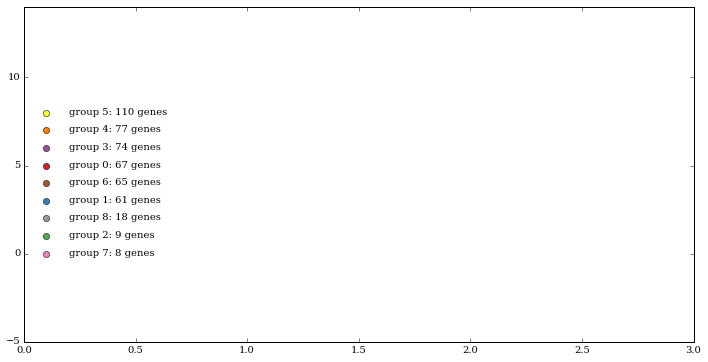

In [433]:
# plot the legend for clusters

gene_to_color = pd.Series(node_to_color)
gene_to_color = gene_to_color.drop_duplicates()

node_to_comm_idx = pd.Series(nx.get_node_attributes(G_hot,'partition'))

comm_to_color={}

for gene in gene_to_color.index.tolist():

    focal_rgba_string = gene_to_color.loc[gene] # reformat the color for python plotting
    focal_rgba = extract_rgba_from_string(focal_rgba_string)

    focal_comm = node_to_comm_idx.loc[gene]

    comm_to_color[focal_comm]=focal_rgba

# now plot the legend
plt.figure(figsize=(12,6))
dcount = -1
for comm in partition.value_counts().keys()[::-1][0:]:
    dcount+=1
    plt.plot([0.1],[dcount],'o',color=comm_to_color[comm])
    plt.annotate('group ' + str(comm)+': '+str(partition.value_counts()[comm]) + ' genes',
                 [0.2,dcount-.1])
    
plt.xlim([0,3])
plt.ylim([-5,len(comm_to_color)+5])
#plt.savefig('cluster_legend.png',dpi=300)
    

In [35]:
# for n in G_hot.nodes():
#     if n.startswith('Wnt') or n.startswith('Notch'):
#         print(n)

# wnt_genes = [n for n in crispr_df.index.tolist() if n.startswith('Wnt')]
# notch_genes = [n for n in crispr_df.index.tolist() if n.startswith('Notch')]
        
# crispr_df.loc[wnt_genes+notch_genes]

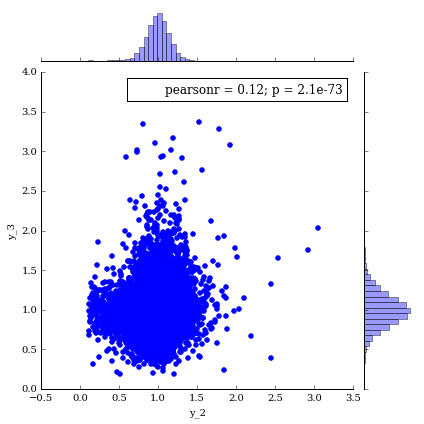

In [52]:
sns.jointplot(x='y_2',y='y_3',data=crispr_df,kind='scatter')

In [75]:
partition = pd.Series(partition)
partition.value_counts()


1    100
3     84
4     77
6     74
5     60
0     47
2     35
7     19
8      4
dtype: int64

In [54]:
# save gene sets for each partition
for c in partition.unique().tolist():
    pd.Series(partition[partition==c].index.tolist()).to_csv('../cluster_genes/cluster_'+str(c)+'.txt',
                                                                    index=False)

In [82]:
focal_cluster=7
# save as a series
pd.Series(partition[partition==focal_cluster].index.tolist()).to_csv('../cluster_genes/cluster_'+str(focal_cluster)+'.txt',
                                                                    index=False)
for g in partition[partition==focal_cluster].index.tolist():
    print(g)

Acly
Gmps
H6pd
Pgd
Pgm1
Pgm2
Prps1
Prps1l1
Prps1l3
Prps2
Rbks
Rpe
Rpia
Taldo1
Tkt
Tktl1
Tktl2
Vps52
Vps53


In [84]:
# print the seed nodes in focal_cluster
for g in partition[partition==focal_cluster].index.tolist():
    if g in seed_genes:
        print(g)

# now print out genes w/ significant RNA scores in each cluster

print(len(partition[partition==focal_cluster]))
g_sig_rna_lfdr = []
for g in partition[partition==focal_cluster].index.tolist():
    if g in rna_df.index.tolist():
        if rna_df.loc[g]['lfdr GFP-NEG']<0.3:
            g_sig_rna_lfdr.append(g)
            
rna_sig_temp = rna_df.loc[g_sig_rna_lfdr][['log2 GFP/NEG','lfdr GFP-NEG']]
rna_sig_temp = rna_sig_temp.sort_values('log2 GFP/NEG')
rna_sig_temp

19


,log2 GFP/NEG,lfdr GFP-NEG
symbol,,


In [55]:
# save the hot nodes for webgestalt enrichment
pd.Series(G_hot.nodes()).to_csv('../cluster_genes/G_hot.txt',sep='\t',index=False)

# run GSEA on ranked hot genes with GSEAPY

In [48]:
import gseapy

In [165]:
# make a .rnk file for gsea
focal_nodes = partition.index.tolist() #partition[partition==4].index.tolist()
hot_rank = rna_df.loc[focal_nodes]['log2 GFP/NEG']
hot_rank = hot_rank.sort_values(ascending=False)
#hot_rank.to_csv('../hot_genes_ranked_rnaLFC.rnk',sep='\t')
hot_rank.head()

symbol
Shh       4.867147
Wnt10a    4.424711
Wnt7a     4.034866
Fzd3      3.880513
Wnt7b     3.726276
Name: log2 GFP/NEG, dtype: float64

In [166]:
cap_names = [n.upper() for n in hot_rank.index.tolist()]
prerank_df = pd.DataFrame({0:cap_names,1:hot_rank.tolist()})

prerank_df.dropna(inplace=True)
prerank_df.head()

,0,1
0,SHH,4.867147
1,WNT10A,4.424711
2,WNT7A,4.034866
3,FZD3,3.880513
4,WNT7B,3.726276


In [167]:
gsea_temp = gseapy.prerank(prerank_df,'/Users/brin/Google_Drive/UCSD/CCBB_tickets/Ideker_17_05_neuro/gsea/canonical_pathways/c2.cp.v6.0.symbols.gmt',
                           weighted_score_type=1,verbose=True,min_size=5,graph_num=10,
                          outdir='GSEA_fdr.3_network_prop')

2017-09-07 16:59:46,998 Parsing data files for GSEA.............................
2017-09-07 16:59:47,000 User Defined gene sets is given.......continue..........
2017-09-07 16:59:48,093 1155 gene_sets have been filtered out when max_size=500 and min_size=5
2017-09-07 16:59:48,096 0174 gene_sets used for further statistical testing.....
2017-09-07 16:59:48,097 Start to run GSEA...Might take a while..................
2017-09-07 16:59:53,847 Start to generate gseapy reports, and produce figures...
2017-09-07 17:00:00,724 Congratulations. GSEApy run successfully................


In [295]:
len(crispr_df)

2373

In [292]:
for g in G_hot.nodes():
    print(g)

Cers2
Prdm10
Actl9
Foxa1
Foxa2
Pdss1
Ctbp2
Pik3ap1
Nog
Hs3st3a1
Klf4
Coq9
Klf1
Clca2
Coq4
Coq7
Coq6
Coq3
Coq2
Zfp446
Isl1
Isl2
C1galt1c1
Tbr1
Akt1
Akt2
Akt3
Fgf8
Fgf4
Fgf2
Col10a1
Ascl1
Kcnq2
Kcnq3
Apoc2
ENSMUSP00000027645
Bcan
Actbl2
Dse
Gm9573
Six3
ENSMUSP00000001365
Cps1
Fgfr1
Pxdc1
Stat4
Stat3
Stat1
Ric3
Hs6st1
Hs6st2
Hs6st3
Rps6kb1
Inhba
Inhbb
Inhbe
B3gat3
B3gat2
B3gat1
Chst11
Chst13
Chst12
Chst15
Chst14
Atp5a1
Etv1
Actg1
Actg2
Chrnb1
Chrnb3
Chrnb2
Chrnb4
Bcor
Ache
Phb2
Coq5
Dbx2
Dbx1
ENSMUSP00000054270
Hlx
Creb1
Foxd1
Wnt3
Hs3st3b1
Bcl2
B4galt7
Ehmt1
B3gnt6
Ehmt2
Lrrk1
Lrrk2
Muc20
Hgf
Sesn2
Hspg2
Coq10b
Coq10a
Rho
Mmp9
Mmp2
Mmp13
Ndst1
Ndst2
Ndst3
Ndst4
Gapdh
Prop1
Nkx2-2
Gm10093
Crebbp
Nkx2-5
Spi1
Pygo1
Tpmt
Alb
Gli1
Igf1
Apob
Ano6
Ano1
Ano2
Usp7
Ctnnb1
Ylpm1
Acly
Top2b
Top2a
Fars2
Igbp1
Actc1
Nkx1-2
Pfas
Vsx2
Smarca2
Smarca4
Foxq1
ENSMUSP00000137145
Shh
Brf1
Setx
Cad
Wnt2b
Prl
Gfm2
Tlx1
Ano10
Gpc3
Actl11
Actl10
Gpc4
Ssbp3
Ssbp2
Ssbp4
Slf1
Bpnt1
Fn1
Ptf1a
Bean1
Agrn
Gfap
Lypd1
P

In [176]:
crispr_T21_df.head()

,PEP,alphaT,FDR
Erh,0.000122,-4.366207,0.000122
Eif2b5,0.000161,-3.824281,0.000141
Rpl12,0.000186,-4.380849,0.000156
Aldoa,0.000317,-4.175077,0.000196
Ftsj3,0.000424,-3.979252,0.000242


,crispr 3DV FDR,crispr 3DV s,crispr 3DV y_1,crispr 3DV y_2,crispr 3DV y_3,crispr T21 FDR,RNA fc GFP/NEG,RNA lfdr GFP-NEG,super-enhancer zscore,network_prop_score,cluster_ID
Actb,0.6159,5.3385,1.1109,1.2595,1.7016,0.018845,-1.615329,0.923235,0.0,0.000407,2
Cdc42,1.0101,2.6676,1.1280,0.7930,0.9377,0.023478,-1.688944,0.882522,0.0,0.000669,2
Il1b,0.9757,3.3078,0.9164,1.1525,1.0957,0.030674,-64.361881,0.003667,0.0,0.001476,0
Myc,0.9873,3.1149,0.8019,1.3742,0.9650,0.032888,-1.025839,0.999236,0.0,0.000287,0
Sptlc2,0.9081,4.1387,0.9451,1.3342,1.2822,0.044117,-1.035367,0.999229,0.0,0.000735,9
Erbb2,0.9728,3.2972,0.9368,1.1723,1.0492,0.046761,10.246641,0.485179,0.0,0.001037,0
Erbb3,0.9158,4.0905,1.1266,1.3684,1.0335,0.053899,8.265974,0.884661,0.0,0.000470,0
Rac1,0.9806,3.1855,1.0709,0.9345,1.0930,0.058982,-1.404894,0.987444,0.0,0.000558,2
Sptlc1,0.9338,3.7780,0.9405,1.1886,1.2627,0.066100,-1.277219,0.993240,0.0,0.000737,9
Hsp90ab1,0.9837,3.1590,0.9620,1.1277,0.9962,0.066582,1.876771,0.766910,0.0,0.000328,2


In [331]:
rna_df.head()

,gene,symbol,description,NEG1,NEG2,NEG3,GFP1,GFP2,GFP3,NEG,GFP,log2 GFP/NEG,fc GFP/NEG,lfdr GFP-NEG,fdr GFP-NEG
symbol,,,,,,,,,,,,,,,
Slc10a2,20494,Slc10a2,"solute carrier family 10, member 2",3,4,5,198,202,218,4,206,5.436202,43.297196,0.000387,0.000387
G0s2,14373,G0s2,G0/G1 switch gene 2,2933,2180,3846,23,27,31,2986,27,-6.731514,-106.264347,0.000621,0.000504
Cd177,68891,Cd177,CD177 antigen,3455,3029,3022,52,79,79,3169,70,-5.513000,-45.664450,0.000688,0.000565
Il1r2,16178,Il1r2,"interleukin 1 receptor, type II",5689,7159,7494,125,130,77,6781,111,-5.959055,-62.209147,0.001087,0.000696
Gpr84,80910,Gpr84,G protein-coupled receptor 84,203,190,213,6,6,9,202,7,-4.795802,-27.776680,0.001274,0.000812


# Network propagation from seed nodes, with z-score 

In [85]:

len(seed_genes)


13

In [116]:
# z-score routine imported from ASD-EPI project (but here we only have one set of seed genes instead of two)
import scipy

seed_genes = np.intersect1d(Gint.nodes(),best_genes_roman)
Fnew = visJS2jupyter.visualizations.network_propagation(Gint,Wprime,seed_genes,alpha=.5,num_its=20)

num_reps=300
Fnew_rand = np.zeros([num_reps,len(Fnew)])
for r in range(num_reps):
    print(r)
    
    p=0
    # resample until degree distributions are not significantly different
    while p<0.1:
        seeds_random = Gint.nodes()
        np.random.shuffle(seeds_random)
        seeds_random = seeds_random[0:len(seed_genes)]
        ks_stat,p=scipy.stats.ks_2samp(pd.Series(Gint.degree(seed_genes)),pd.Series(Gint.degree(seeds_random)))
        
    print(p)
    
    Fnew_rand_tmp = visJS2jupyter.visualizations.network_propagation(Gint,Wprime,seeds_random,alpha=.5,num_its=20)
    Fnew_rand_tmp.loc[seeds_random]=np.nan # set seeds to nan so they don't bias results
    Fnew_rand[r] = Fnew_rand_tmp.loc[Fnew.index.tolist()]

    

0
0.488908215134
1
0.22641589036
2
0.22641589036
3
0.488908215134
4
0.828104728915
5
0.488908215134
6
0.22641589036
7
0.828104728915
8
0.488908215134
9
0.488908215134
10
0.488908215134
11
0.22641589036
12
0.488908215134
13
0.488908215134
14
0.488908215134
15
0.488908215134
16
0.22641589036
17
0.22641589036
18
0.22641589036
19
0.22641589036
20
0.22641589036
21
0.22641589036
22
0.22641589036
23
0.22641589036
24
0.22641589036
25
0.488908215134
26
0.488908215134
27
0.22641589036
28
0.488908215134
29
0.22641589036
30
0.22641589036
31
0.488908215134
32
0.22641589036
33
0.488908215134
34
0.22641589036
35
0.22641589036
36
0.22641589036
37
0.488908215134
38
0.22641589036
39
0.488908215134
40
0.828104728915
41
0.488908215134
42
0.22641589036
43
0.488908215134
44
0.488908215134
45
0.22641589036
46
0.22641589036
47
0.22641589036
48
0.22641589036
49
0.22641589036
50
0.22641589036
51
0.828104728915
52
0.488908215134
53
0.22641589036
54
0.828104728915
55
0.22641589036
56
0.488908215134
57
0.226415890

In [117]:
z_score = (Fnew-np.nanmean(Fnew_rand,axis=0))/np.nanstd(Fnew_rand,axis=0)

In [118]:
z_score.sort_values(ascending=False,inplace=True)

Fnew_rand_df = pd.DataFrame(Fnew_rand).T
Fnew_rand_df.index=Fnew.index

top_idx = z_score.head(50).index.tolist()

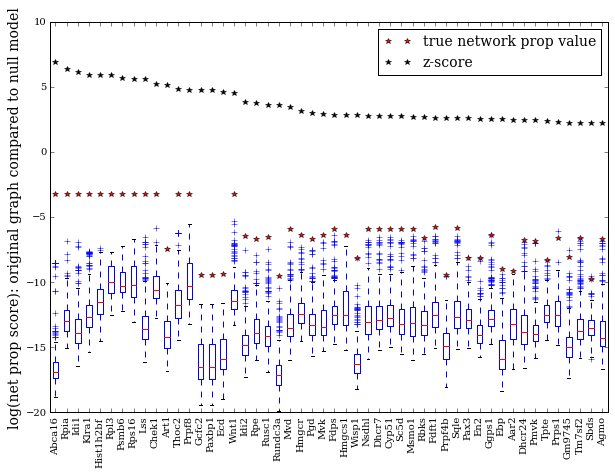

In [120]:

plt.figure(figsize=[10,7])

# filter out nans
data = np.log(np.matrix(Fnew_rand_df.loc[top_idx].T))
mask = ~np.isnan(data)
filtered_data = [d[m] for d, m in zip(data.T, mask.T)]
tmp=plt.boxplot(filtered_data)

plt.plot(range(1,51),np.log(Fnew.loc[top_idx]),'r*',label='true network prop value')
plt.plot(range(1,51),np.log(z_score.loc[top_idx]),'k*',label='z-score')
plt.ylabel('log(net prop score): original graph compared to null model',fontsize=14)
plt.xticks(range(1,51),top_idx,rotation=90)
plt.legend(loc='best',fontsize=14)
plt.grid('off')


<matplotlib_venn._common.VennDiagram instance at 0x116de6b48>

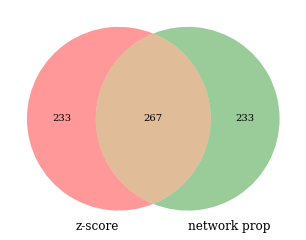

In [121]:
from matplotlib_venn import venn2
# how much overlap btwn zscore and Fnew??
z_score.sort_values(ascending=False,inplace=True)
Fnew.sort_values(ascending=False,inplace=True)
venn2([set(z_score.head(500).index.tolist()),set(Fnew.head(500).index.tolist())],set_labels=('z-score','network prop'))


In [130]:
# likelihood of observed overlap btwn heat and z-score (hypergeom test)
M = len(Fnew)-len(seed_genes)
n = 500-len(seed_genes) # subtract number common to both sets
N= 500-len(seed_genes)
x = 225-len(seed_genes)
-scipy.stats.hypergeom.logsf(x,M,n,N)

231.78134691981856

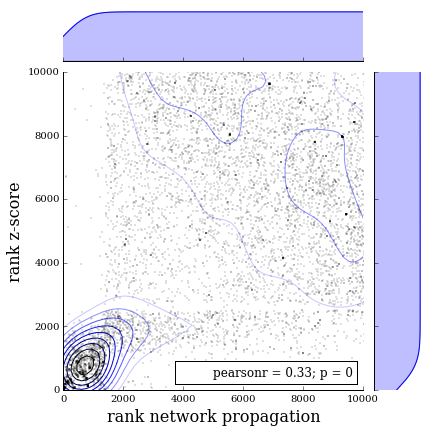

In [122]:
# ---------------------------------------------
# TRY PLOTTING THE ZSCORE RANKS VS FNEW RANKS!!
# ---------------------------------------------

Fnew_rank = pd.Series(range(len(Fnew)),index=Fnew.index)

z_score_rank = pd.Series(range(len(z_score)),index=z_score.index)

rank_rank_jp = sns.jointplot(Fnew_rank.loc[z_score_rank.index],z_score_rank,kind='kde',shade=False,
                            xlim=[0,10000],ylim=[0,10000])
rank_rank_jp.ax_joint.set_xlabel('rank network propagation',fontsize=16)
rank_rank_jp.ax_joint.set_ylabel('rank z-score',fontsize=16)

rank_rank_jp.ax_joint.plot(Fnew_rank.loc[z_score_rank.index],z_score_rank,'k.',ms=1,alpha=.5)


In [124]:
hot_genes = z_score[z_score>2].index.tolist()

# ---------- Just hot genes --------------------
G_hot = nx.subgraph(Gint,hot_genes)

# -------- IMPROVE THIS PART: add superenhancers to subgraph ---------
#G_hot = nx.subgraph(Gint,hot_genes+SE_sig.index.tolist()) 
# ----------------------------------------------------------------------

# --------- try subsetting by genes with lfdr < 0.5 -------------------
# genes_keep = []
# for g in hot_genes:
#     if g in crispr_df.index.tolist(): # check that g is in crispr_df
#         if crispr_df.loc[g]['lfdr']<0.5:
#             genes_keep.append(g)
        
# G_hot = nx.subgraph(G_hot,genes_keep)
# ----------------------------------------------------------------------

G_hot = max(nx.connected_component_subgraphs(G_hot), key=len) # take the LCC
len(G_hot.nodes())

493

In [125]:
# plot the hot subnetwork
# add pval and fc as node attributes
#nx.set_node_attributes(G_sub,'pval',dict(crispr_df.loc[G_sub.nodes()]['Pval']))
nx.set_node_attributes(G_hot,'FDR',
                       dict(crispr_df.loc[G_hot.nodes()]['FDR']))
nx.set_node_attributes(G_hot,'Statistic',
                       dict(crispr_df.loc[G_hot.nodes()]['s']))

# add rna fc as node attributes
nx.set_node_attributes(G_hot,'rna_logFC',dict(rna_df.loc[G_hot.nodes()]['log2 GFP/NEG']))
nx.set_node_attributes(G_hot,'rna_lfdr',dict(rna_df.loc[G_hot.nodes()]['lfdr GFP-NEG']))

# cluster the network
partition = community.best_partition(G_hot)
nx.set_node_attributes(G_hot,'partition',partition)
partition= pd.Series(partition)

In [126]:
pos = nx.spring_layout(G_hot,weight=None,k=.1)

#pos = bias_position_by_partition(pos,partition,r=.7,use_orig_angle=False)

In [128]:
# draw the network



nodes = G_hot.nodes()
nodes_data = G_hot.nodes(data=True)
edges = G_hot.edges()
numnodes = len(nodes)
numedges = len(edges)


node_to_title = {}
node_to_size = {}
node_to_HL = {}
node_to_shape={}
node_to_label={}
for node in nodes_data:
    node_to_title[node[0]]=node[0]+': crispr FDR = '+str(node[1]['FDR'])+'<br/>crispr stat = ' + str(node[1]['Statistic'])
    node_to_title[node[0]]+='<br/>group = ' + str(partition.loc[node[0]])
    node_to_title[node[0]]+='<br/>rna log2FC = ' + str(node[1]['rna_logFC'])
    node_to_title[node[0]]+='<br/>rna lfdr = ' + str(node[1]['rna_lfdr'])
    
    # only label seed nodes or significant nodes
    if node[0] in crispr_df.index:
        if (crispr_df.loc[node[0]]['FDR']<0.3): #in seed_genes:
            node_to_label[node[0]]=node[0]
        else:
            node_to_label[node[0]]=''
            
        # check if node is significant in rnaseq, if so label it
        if node[0] in rna_df.index.tolist():
            if rna_df.loc[node[0]]['lfdr GFP-NEG']<0.3:
                if node_to_label[node[0]]=='':
                    node_to_label[node[0]]=node[0]
    else:
        node_to_label[node[0]]=''

    #node_to_size[node[0]]=-np.log(node[1]['lfdr'])-1.2 # subtract log(0.3)
    #node_to_size[node[0]]=np.abs(node[1]['Statistic'])-5 # map size to statistic
    #node_to_size[node[0]]=np.abs(node[1]['rna_logFC'])
    node_to_size[node[0]]=-np.log(node[1]['rna_lfdr'])*3+2
    
    if node[0] in best_genes_roman:
        node_to_HL[node[0]]=1
        node_to_size[node[0]]=5
    else:
        node_to_HL[node[0]]=0
        
    if node[0] in SE_sig.index.tolist():
        node_to_shape[node[0]]='triangle'
        #node_to_size[node[0]]=4
    else:
        node_to_shape[node[0]]='dot'
        #node_to_size[node[0]]=node[1]['-log10_pval_avg']-2

node_to_color = return_node_to_color(G_hot,'partition',mpl.cm.Set1,color_max_frac=1)
#node_to_color = return_node_to_color(G_hot,'logFC_avg',mpl.cm.Blues_r,vmax=0,vmin=-3)
#node_to_color = return_node_to_color(G_hot,'rna_logFC',mpl.cm.coolwarm,vmax=5,vmin=-5)

nodes_dict = [{"id":n,"color":node_to_color[n],
               "node_size":node_to_size[n],
               "title":node_to_title[n],
               "border_width":node_to_HL[n],
               "node_shape":node_to_shape[n],
               "node_label":node_to_label[n],
              "x":pos[n][0]*1000,
              "y":pos[n][1]*1000} for n in nodes
              ]
node_map = dict(zip(nodes,range(len(nodes))))  # map to indices for source/target in edges


# make the within-group edges darker
edge_to_color={}
for e in edges:
    p1 = partition[e[0]]
    p2 = partition[e[1]]
    if p1==p2:
        edge_to_color[e]="rgba(1, 117, 112,.1)"
    else:
        edge_to_color[e]="rgba(181, 227, 217,.05)"
#edge_to_color = return_edge_to_color(G_hot,field_to_map='weight',cmap=mpl.cm.BuGn,vmin=200,alpha=.2)
    
edges_dict = [{"source":node_map[edges[i][0]], "target":node_map[edges[i][1]], 
              "color":edge_to_color[edges[i]],"title":'test'} for i in range(len(edges))]

# set some network-wide styles
visJS2jupyter.visJS_module.visjs_network(nodes_dict,edges_dict,
                          node_size_multiplier=5,
                          node_size_field='node_size',
                          node_size_transform = 'Math.sqrt',
                          node_color_highlight_border='red',
                          node_color_highlight_background='#D3918B',
                          node_color_hover_border='blue',
                          node_color_hover_background='#8BADD3',
                          node_label_field='node_label',
                          node_font_size=30,
                          physics_enabled=False,
                          edge_color_highlight='#8A324E',
                          edge_color_hover='#8BADD3',
                          edge_width=1, 
                          edge_smooth_enabled=False,
                          edge_smooth_type='cubicBezier', 
                          edge_smooth_roundness=0.5,
                          scaling_factor=1,
                          node_scaling_label_draw_threshold=0,
                          graph_id=2,
                          graph_title='CRISPR network- propagation from FDR < 0.3, Z-score')

256.0
0.0
7


In [151]:
comm_to_color

{0: [0.890625, 0.1015625, 0.109375, 1.0],
 1: [0.2265625, 0.515625, 0.6640625, 1.0],
 2: [0.38671875, 0.57421875, 0.390625, 1.0],
 3: [0.76171875, 0.3828125, 0.3671875, 1.0],
 4: [1.0, 0.7890625, 0.11328125, 1.0],
 5: [0.75, 0.52734375, 0.16796875, 1.0],
 6: [0.92578125, 0.48046875, 0.671875, 1.0],
 7: [0.59765625, 0.59765625, 0.59765625, 1.0]}

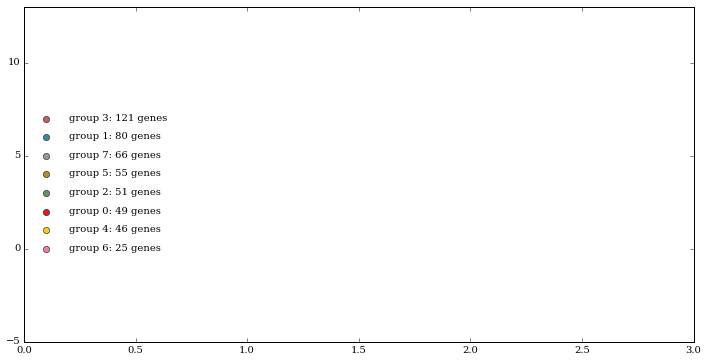

In [152]:
# plot the legend for clusters

gene_to_color = pd.Series(node_to_color)
gene_to_color = gene_to_color.drop_duplicates()

node_to_comm_idx = pd.Series(nx.get_node_attributes(G_hot,'partition'))

comm_to_color={}

for gene in gene_to_color.index.tolist():

    focal_rgba_string = gene_to_color.loc[gene] # reformat the color for python plotting
    focal_rgba = extract_rgba_from_string(focal_rgba_string)

    focal_comm = node_to_comm_idx.loc[gene]

    comm_to_color[focal_comm]=focal_rgba

# now plot the legend
plt.figure(figsize=(12,6))
dcount = -1
for comm in partition.value_counts().keys()[::-1][:]:
    dcount+=1
    plt.plot([0.1],[dcount],'o',color=comm_to_color[comm])
    plt.annotate('group ' + str(comm)+': '+str(partition.value_counts()[comm]) + ' genes',
                 [0.2,dcount-.1])
    
plt.xlim([0,3])
plt.ylim([-5,len(comm_to_color)+5])
plt.savefig('cluster_legend.png',dpi=300)
    

In [130]:
# save gene sets for each partition
for c in partition.unique().tolist():
    pd.Series(partition[partition==c].index.tolist()).to_csv('../cluster_genes/cluster_'+str(c)+'.txt',
                                                                    index=False)

In [131]:
# save the hot nodes for webgestalt enrichment
pd.Series(G_hot.nodes()).to_csv('../cluster_genes/G_hot.txt',sep='\t',index=False)

In [132]:
partition = pd.Series(partition)
partition.value_counts()


3    121
1     80
7     66
5     55
2     51
0     49
4     46
6     25
dtype: int64

In [147]:
focal_cluster=6
# print the seed nodes in focal_cluster
for g in partition[partition==focal_cluster].index.tolist():
    if g in seed_genes:
        print(g)

# now print out genes w/ significant RNA scores in each cluster

print(len(partition[partition==focal_cluster]))
g_sig_rna_lfdr = []
for g in partition[partition==focal_cluster].index.tolist():
    if g in rna_df.index.tolist():
        if rna_df.loc[g]['lfdr GFP-NEG']<0.3:
            g_sig_rna_lfdr.append(g)
            
rna_sig_temp = rna_df.loc[g_sig_rna_lfdr][['log2 GFP/NEG','lfdr GFP-NEG']]
rna_sig_temp = rna_sig_temp.sort_values('log2 GFP/NEG')
rna_sig_temp

Rpia
25


,log2 GFP/NEG,lfdr GFP-NEG
symbol,,


493

# How significant are number of CRISPR genes found in neighborhood of Roman's 5 genes?

In [126]:
Fnew = visJS2jupyter.visualizations.network_propagation(Gint,Wprime,seed_genes)
Fnew.sort(ascending=False)
Fnew = pd.DataFrame(Fnew,columns=['heat'])
Fnew['rank']=range(len(Fnew))
Fnew.head()

,heat,rank
Isl2,0.126436,0
Bean1,0.126376,1
Hs3st3b1,0.126111,2
Sox4,0.125484,3
Zfp592,0.006908,4


(array([ 279.,  225.,  201.,  212.,  215.,  222.,  213.,  220.,  166.,  169.]),
 array([     0. ,   1963.6,   3927.2,   5890.8,   7854.4,   9818. ,
         11781.6,  13745.2,  15708.8,  17672.4,  19636. ]),
 <a list of 10 Patch objects>)

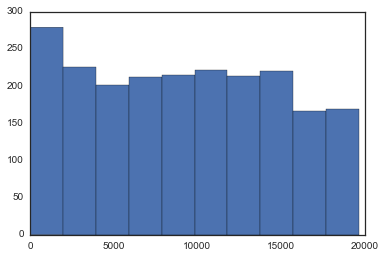

In [147]:
crispr_in_string = list(np.intersect1d(crispr_df.index.tolist(),Fnew.index.tolist()))

Fnew_crispr_rank = Fnew.loc[crispr_in_string]['rank']
Fnew_crispr_rank = Fnew_crispr_rank.dropna()

plt.hist(Fnew_crispr_rank)

In [190]:
Frand_crispr_rank.sort(ascending=True)
print(sum(Frand_crispr_rank<900))

print(sum(Fnew_crispr_rank<900))

73
141


In [116]:
crispr_sig_genes = crispr_df.index.tolist()

num_found_N={}
for i in range(1,2000,50):
    num_N_temp = len(np.intersect1d(crispr_sig_genes,Fnew.head(i).index.tolist()))
    num_found_N[i]=num_N_temp
    
num_found_N = pd.Series(num_found_N)
num_found_N.head()
    

1       1
51     11
101    22
151    30
201    39
dtype: int64

In [187]:
num_found_N_rand=pd.DataFrame()
Frand_df = pd.DataFrame()
for r in range(50):
    print(r)
    #pick random seed genes
    rand_seeds = Gint.nodes()
    np.random.shuffle(rand_seeds)
    rand_seeds = rand_seeds[0:4]

    Frand = visJS2jupyter.visualizations.network_propagation(Gint,Wprime,rand_seeds)
    Frand_df[r] = Frand
    Frand.sort(ascending=False)

    num_found_N_rand_temp={}
    for i in range(1,2000,50):
        num_N_temp = len(np.intersect1d(crispr_sig_genes,Frand.head(i).index.tolist()))
        num_found_N_rand_temp[i]=num_N_temp

    num_found_N_rand[r] = pd.Series(num_found_N_rand_temp)
    #print(num_found_N_rand.head())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


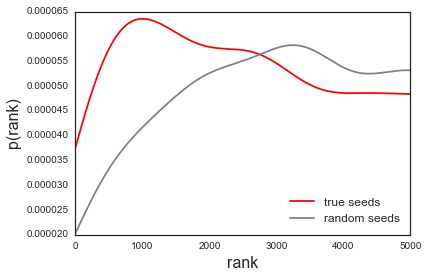

In [193]:
Frand = Frand_df.mean(axis=1)

Frand = pd.DataFrame(Frand,columns=['heat'])
Frand['rank']=range(len(Frand))
Frand_crispr_rank = Frand.loc[crispr_in_string]['rank']
Frand_crispr_rank = Frand_crispr_rank.dropna()
Frand_crispr_rank.head()

from scipy.stats import gaussian_kde
density = gaussian_kde(Fnew_crispr_rank)
density.covariance_factor = lambda : .1
density._compute_covariance()

xs = np.linspace(0,5000,500)
plt.plot(xs,density(xs),'r',label='true seeds')

density_rand = gaussian_kde(Frand_crispr_rank)
density_rand.covariance_factor = lambda : .1
density_rand._compute_covariance()
plt.plot(xs,density_rand(xs),color='gray',label='random seeds')


plt.legend(loc='best',fontsize=12)
plt.xlabel('rank',fontsize=16)
plt.ylabel('p(rank)',fontsize=16)


In [209]:
Frand_crispr_heat = np.log(Frand.loc[crispr_in_string]['heat'])
Frand_crispr_heat = Frand_crispr_heat.dropna()
Frand_crispr_heat.tail()

Zscan22   -11.848599
Zswim3    -17.051309
Zxdc      -11.008937
Zyg11b    -13.239849
Zzz3      -13.022938
Name: heat, dtype: float64

In [214]:
Frand_crispr_heat = Frand_crispr_heat[Frand_crispr_heat>-50]
Frand_crispr_heat.min()

-18.121031726652284

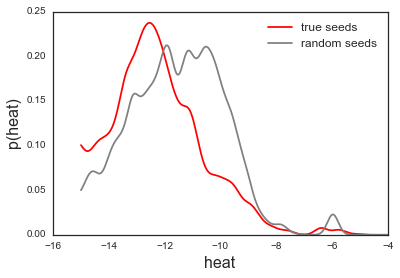

In [215]:
# doesn't work as well for heat!

Frand = Frand_df.mean(axis=1)

Frand = pd.DataFrame(Frand,columns=['heat'])
Frand['rank']=range(len(Frand))
Frand_crispr_heat = np.log(Frand.loc[crispr_in_string]['heat'])
Frand_crispr_heat = Frand_crispr_heat.dropna()
Frand_crispr_heat = Frand_crispr_heat[Frand_crispr_heat>-50]
Frand_crispr_heat.head()

Fnew_crispr_heat = np.log(Fnew.loc[crispr_in_string]['heat'])
Fnew_crispr_heat = Fnew_crispr_heat[Fnew_crispr_heat>-50]
Fnew_crispr_heat = Fnew_crispr_heat.dropna()

from scipy.stats import gaussian_kde
density = gaussian_kde(Fnew_crispr_heat)
density.covariance_factor = lambda : .1
density._compute_covariance()

xs = np.linspace(-15,-4,500)
plt.plot(xs,density(xs),'r',label='true seeds')

density_rand = gaussian_kde(Frand_crispr_heat)
density_rand.covariance_factor = lambda : .1
density_rand._compute_covariance()
plt.plot(xs,density_rand(xs),color='gray',label='random seeds')
#plt.xlim([-.001,.025])


plt.legend(loc='best',fontsize=12)
plt.xlabel('heat',fontsize=16)
plt.ylabel('p(heat)',fontsize=16)


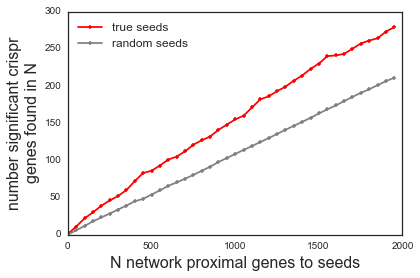

In [198]:
plt.plot(num_found_N.index.tolist(),num_found_N.tolist(),'r.-',label='true seeds')http://localhost:8888/notebooks/Google_Drive/UCSD/CCBB_tickets/CTRI/Reya/notebooks/network_analysis_CRISPR_essential_genes.ipynb#
plt.plot(num_found_N_rand.index.tolist(),num_found_N_rand.mean(axis=1).tolist(),'.-',color='gray',label='random seeds')

plt.xlabel('N network proximal genes to seeds',fontsize=16)
plt.ylabel('number significant crispr \ngenes found in N',fontsize=16)
plt.legend(loc='best',fontsize=12)